In [93]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from plotly import plotly as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

In [94]:
df_cotista = df = pd.read_excel('dataset_outliers.xlsx')

In [98]:
df_cotista["idCotista"].unique().tolist().__len__()

1432

In [13]:
df = pd.read_excel('dataset_outliers.xlsx')

In [14]:
df = df[["idCotista", 'idOperacao', "dataOperacao", "valorLiquido"]]

In [15]:
df.columns = ["cotista", "operacao", "data", "valor_liquido"]

In [16]:
df["data"].iloc[0]

'2013-07-31'

In [17]:
df['data'] = df.apply(lambda x : datetime.strptime(x["data"], "%Y-%m-%d").date(), axis=1)

In [18]:
dt = df.groupby('cotista').count().reset_index()[["cotista", "data"]]

In [19]:
lista_cotista = dt[dt['data']>3]["cotista"].tolist()

In [99]:
lista_cotista.__len__()

119

In [20]:
df[df['cotista']==20003955]

,cotista,operacao,data,valor_liquido
2413,20003955,19257,2019-06-06,20000.0


In [21]:
dataset = df[df['cotista'].isin(lista_cotista)]

In [22]:
dataset.head()

,cotista,operacao,data,valor_liquido
0,30,2970,2013-07-31,6563437.65
1,30,2971,2013-12-30,28548737.73
2,30,3300,2017-01-19,4408362.09
3,30,3404,2018-03-27,3276325.06
56,18508197,2846,2017-07-24,281253.82


In [81]:
def get_data(id_cotista, dataset):
    dt = dataset[dataset["cotista"]==id_cotista]
    dt = dt.sort_values("data")
    media = dt['valor_liquido'].mean()
    _df = dt[['data']].diff().dropna()
    _df["delta"] = _df.apply(lambda x : x["data"].days, axis=1)
    val = dt['valor_liquido'].tolist()[1:]
    _df['valor'] = val
    op = dt['operacao'].tolist()[1:]
    _df["operacao"] = op

    _df["ref_media"] = _df['valor']/media

    _df = _df[["operacao", "delta", "valor", "ref_media"]]
    return _df

def get_outlier(id_cotista, dataset):
    _df = get_data(id_cotista, dataset)
    _df.index = _df.operacao
    _df.drop(columns=["operacao"], axis=1, inplace=True)

    X = _df.copy()
    
    outlier_detect =  IsolationForest(n_estimators=100,
                                     max_samples=1000, contamination=.05, max_features=X.shape[1], random_state=1)

    outlier_detect.fit(X)

    outliers_predicted = outlier_detect.predict(X)

    _df["outlier"] = outliers_predicted
    res = _df.reset_index()
    res["cotista"] = id_cotista
#     res.drop(columns=['index'], axis=1, inplace=True)
    return res

def nova_operacao(id_cotista, valor, dataset, data=datetime.now().date()):
    dt = pd.DataFrame()
    dt["cotista"] = [id_cotista]
    dt['operacao'] = [0]
    dt['valor_liquido'] = [valor]
    dt["data"] = [data]
    df = dataset.copy()
    df = pd.concat([df, dt])
    res = get_outlier(id_cotista, df)
    return res

def plot(dp):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('delta', fontsize = 15)
    ax.set_ylabel('ref_media', fontsize = 15)
    ax.set_title('Anomaly detection Cotista : {}'.format(dp['cotista'].iloc[0]), fontsize = 20)
    targets = ["outlier", "inlier"]
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = dp['outlier'] == -1 if target == "outlier" else dp['outlier'] == 1
        ax.scatter(dp.loc[indicesToKeep, 'delta']
                   , dp.loc[indicesToKeep, 'ref_media']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

In [24]:
_df = get_data(18508197, dataset)

In [25]:
_df

,operacao,delta,valor,ref_media
57,2847,102,58669.03,0.544685
59,2848,35,57902.73,0.537571
58,2849,143,33021.69,0.306574


In [94]:
_df.index = _df.operacao

_df.drop(columns=["operacao"], axis=1, inplace=True)


In [97]:
_df

,delta,valor,ref_media
operacao,,,
2847,102,58669.03,0.544685
2848,35,57902.73,0.537571
2849,143,33021.69,0.306574


In [41]:
dataset[dataset["cotista"]==30]

,cotista,operacao,data,valor_liquido
0,30,2970,2013-07-31,6563437.65
1,30,2971,2013-12-30,28548737.73
2,30,3300,2017-01-19,4408362.09
3,30,3404,2018-03-27,3276325.06


In [43]:
d= get_outlier(30, dataset)

In [44]:
d

,operacao,delta,valor,ref_media,outlier,cotista
0,2971,152,28548737.73,2.668302,-1,30
1,3300,1116,4408362.09,0.412027,1,30
2,3404,432,3276325.06,0.306221,1,30


In [45]:
d2 =  nova_operacao(30, 1000000000, dataset, data=datetime(2013, 8, 2).date())

In [46]:
d2

,operacao,delta,valor,ref_media,outlier,cotista
0,0,2,1.000000e+09,4.794798,-1,30
1,2971,150,2.854874e+07,0.136885,1,30
2,3300,1116,4.408362e+06,0.021137,1,30
3,3404,432,3.276325e+06,0.015709,1,30


In [47]:
fr = []
for el in dataset['cotista'].unique().tolist():
    res = get_outlier(el, dataset)
    fr.append(res)

In [48]:
final = pd.concat(fr)

In [103]:
final.head()

,operacao,delta,valor,ref_media,outlier,cotista
0,2971,152,28548737.73,2.668302,-1,30
1,3300,1116,4408362.09,0.412027,1,30
2,3404,432,3276325.06,0.306221,1,30
0,2847,102,58669.03,0.544685,1,18508197
1,2848,35,57902.73,0.537571,1,18508197


In [62]:
final[final["outlier"]==-1].sort_values('ref_media', ascending=False).head(10)

,operacao,delta,valor,ref_media,outlier,cotista
3,2895,2,142616.16,5.530678,-1,20000044
11,3794,101,5969514.47,4.495723,-1,18513361
11,3157,78,50591.54,4.453233,-1,20000031
1,4167,309,79469.17,3.894609,-1,20000079
3,3906,13,60027.23,3.248768,-1,20001181
0,2910,0,348260.05,3.246236,-1,18511773
4,4574,249,516822.15,3.170129,-1,20000363
2,4030,0,25694.97,2.825586,-1,20000083
1,3116,19,108748.20,2.744584,-1,20000963
0,3224,408,40097.01,2.718461,-1,20000026


In [69]:
final[final["outlier"]==-1].sort_values('delta').head()

,operacao,delta,valor,ref_media,outlier,cotista
1,5269,0,50000.00,0.534188,-1,20002222
2,4030,0,25694.97,2.825586,-1,20000083
2,19228,0,10000.00,0.792390,-1,20001264
0,3732,0,5115.67,0.046340,-1,20001278
0,3070,0,108022.77,1.539464,-1,18513969


In [60]:
final[final["cotista"]==20000044]

,operacao,delta,valor,ref_media,outlier,cotista
0,2892,57,2708.39,0.105032,1,20000044
1,2893,106,12700.72,0.492536,1,20000044
2,2894,108,5000.15,0.193907,1,20000044
3,2895,2,142616.16,5.530678,-1,20000044
4,3204,152,1056.60,0.040975,1,20000044
5,3205,22,2097.69,0.081349,1,20000044


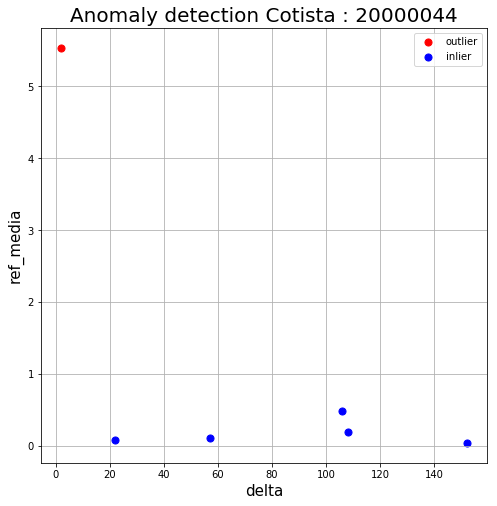

In [83]:
df_plot = final[final["cotista"]==20000044]
plot(df_plot)

In [61]:
final[final["cotista"]==20001181]

,operacao,delta,valor,ref_media,outlier,cotista
0,4153,11,15372.12,0.831963,1,20001181
1,3870,62,5030.75,0.272272,1,20001181
2,4229,7,5019.94,0.271687,1,20001181
3,3906,13,60027.23,3.248768,-1,20001181
4,18935,96,10000.00,0.541216,1,20001181


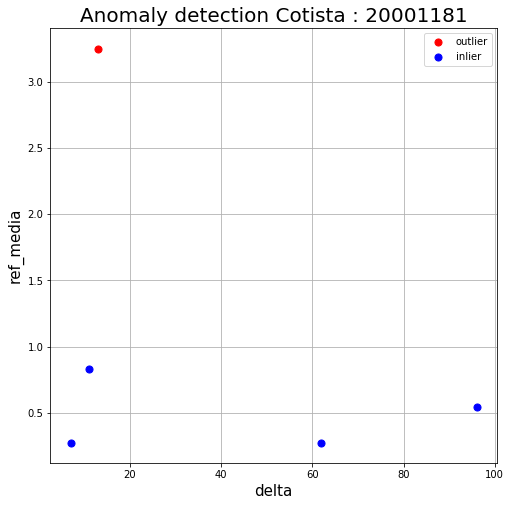

In [84]:
df_plot = final[final["cotista"]==20001181]
plot(df_plot)

In [63]:
final[final["cotista"]==20000083]

,operacao,delta,valor,ref_media,outlier,cotista
0,3365,315,2244.92,0.246866,1,20000083
1,4029,274,5213.27,0.573285,1,20000083
2,4030,0,25694.97,2.825586,-1,20000083
3,4019,147,5001.76,0.550026,1,20000083


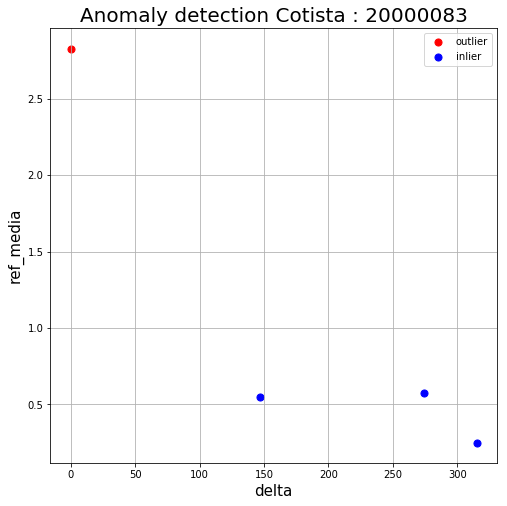

In [85]:
df_plot = final[final["cotista"]==20000083]
plot(df_plot)

In [64]:
df[df['cotista']==20000083]1

,cotista,operacao,data,valor_liquido
980,20000083,3504,2017-02-08,7313.47
981,20000083,3365,2017-12-20,2244.92
982,20000083,4019,2019-02-14,5001.76
983,20000083,4029,2018-09-20,5213.27
984,20000083,4030,2018-09-20,25694.97


In [65]:
final[final['cotista']==18511773]

,operacao,delta,valor,ref_media,outlier,cotista
0,2910,0,348260.05,3.246236,-1,18511773
1,4281,234,25514.56,0.237829,1,18511773
2,3792,28,25294.55,0.235778,1,18511773


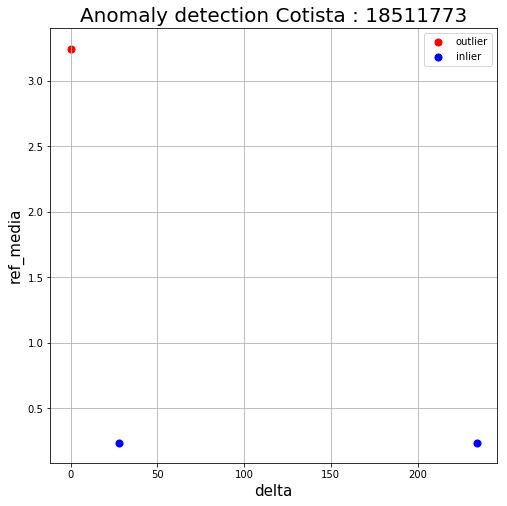

In [86]:
df_plot = final[final['cotista']==18511773]
plot(df_plot)

In [108]:
d

Index(['idOperacao', 'idCotista', 'codigoInterface', 'idCarteira', 'nomeFundo',
       'dataOperacao', 'dataConversao', 'dataLiquidacao', 'dataAgendamento',
       'tipoOperacao', 'tipoResgate', 'idPosicaoResgatada',
       'idFormaLiquidacao', 'quantidade', 'cotaOperacao', 'valorBruto',
       'valorLiquido', 'valorIR', 'valorIOF', 'valorCPMF', 'valorPerformance',
       'prejuizoUsado', 'rendimentoResgate', 'variacaoResgate',
       'cpfCnpjCarteira', 'cpfCnpjCotista', 'fonte', 'idConta',
       'cotaInformada', 'idAgenda', 'idOperacaoResgatada', 'codigoAnbima',
       'idCotista.1', 'nomeRazaoSocial', 'cpfCnpj', 'distribuidora', 'email',
       'convidado', 'idTipoCotista', 'isentoIR', 'isentoIOF', 'tipo',
       'statusAtivo', 'RegimeEspecialTributacao', 'tipoCotistaCVM',
       'CodigoInterface', 'telefone', 'estadoCivil', 'documentos', 'sexo',
       'dataNascimento', 'cotitular', 'idTitular', 'dataAtualizacaoCadastro',
       'dataVigenciaSuitability', 'perfilCotista', 'nomePai'

In [109]:
df[df['idCotista']==18511836][["idOperacao", 'nomeFundo']]

,idOperacao,nomeFundo
543,5108,CAPTALYS MC FC FI MULT
544,5109,CAPTALYS MC FC FI MULT
545,18892,CAPTALYS ORION FC FI MULT CRED PRIV
546,2976,CAPTALYS ORION FC FI MULT CRED PRIV


In [106]:
dataset[dataset["cotista"]==18511836]

,cotista,operacao,data,valor_liquido
543,18511836,5108,2018-05-25,307000.00
544,18511836,5109,2018-05-24,837000.00
545,18511836,18892,2019-05-17,1830000.00
546,18511836,2976,2019-02-12,1722173.47


In [71]:
dp = final[final['cotista']==18511836]
dp

,operacao,delta,valor,ref_media,outlier,cotista
0,5108,1,307000.00,0.261489,-1,18511836
1,2976,263,1722173.47,1.466874,1,18511836
2,18892,94,1830000.00,1.558716,1,18511836


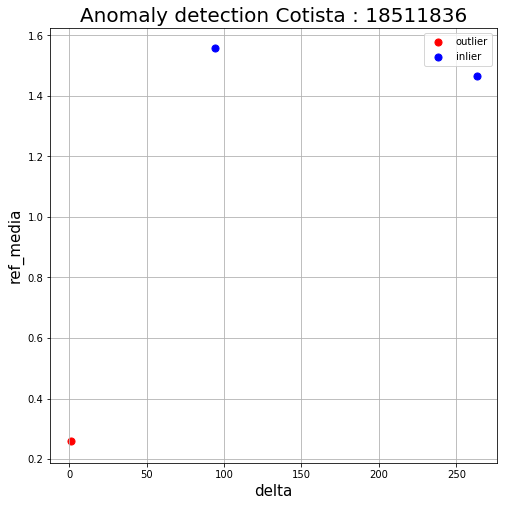

In [79]:
plot(dp)

In [91]:
final[final['cotista']==20001278]

,operacao,delta,valor,ref_media,outlier,cotista
0,3732,0,5115.67,0.046340,-1,20001278
1,3788,35,202492.44,1.834249,1,20001278
2,3796,1,101178.21,0.916508,1,20001278
3,3820,5,101117.46,0.915958,1,20001278
4,3863,8,201598.23,1.826149,1,20001278


In [110]:
dataset[dataset["cotista"]==20001278]

,cotista,operacao,data,valor_liquido
1777,20001278,4198,2018-11-29,50869.81
1778,20001278,3732,2018-11-29,5115.67
1779,20001278,3820,2019-01-09,101117.46
1780,20001278,3788,2019-01-03,202492.44
1781,20001278,3863,2019-01-17,201598.23
1782,20001278,3796,2019-01-04,101178.21


In [111]:
df[df['idCotista']==20001278][["idOperacao", "nomeFundo", "dataOperacao"]]

,idOperacao,nomeFundo,dataOperacao
1777,4198,CAPTALYS PANORAMA FC FI MULT CRED PRIV,2018-11-29
1778,3732,CAPTALYS PANORAMA FC FI MULT CRED PRIV,2018-11-29
1779,3820,CAPTALYS PANORAMA FC FI MULT CRED PRIV,2019-01-09
1780,3788,CAPTALYS PANORAMA FC FI MULT CRED PRIV,2019-01-03
1781,3863,CAPTALYS PANORAMA FC FI MULT CRED PRIV,2019-01-17
1782,3796,CAPTALYS PANORAMA FC FI MULT CRED PRIV,2019-01-04


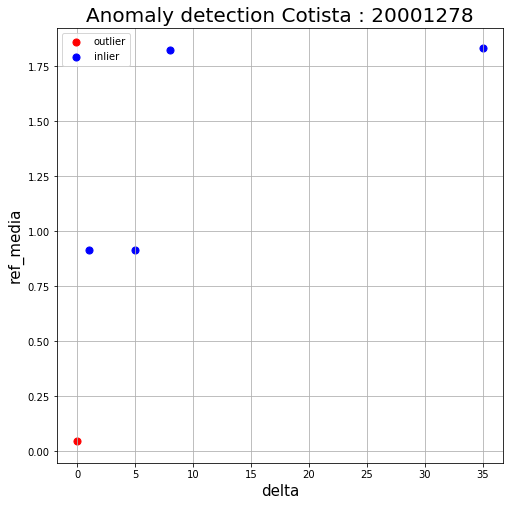

In [92]:
df_plot = final[final['cotista']==20001278]
plot(df_plot)

In [51]:
df = dataset.copy()

In [56]:
df[df['cotista']==18508207]

,cotista,operacao,data,valor_liquido
70,18508207,2955,2017-09-11,119894.08
71,18508207,2954,2017-07-20,954915.18
72,18508207,2956,2017-12-08,868541.09
73,18508207,2957,2018-04-30,121079.53
74,18508207,2958,2018-06-07,190217.33


In [115]:
dataset[dataset['cotista']==18508197]

,cotista,operacao,data,valor_liquido
56,18508197,2846,2017-07-24,281253.82
57,18508197,2847,2017-11-03,58669.03
58,18508197,2849,2018-04-30,33021.69
59,18508197,2848,2017-12-08,57902.73


In [116]:
final[final['cotista']==18508197]

,operacao,delta,valor,ref_media,outlier,cotista
0,2847,102,58669.03,0.544685,1,18508197
1,2848,35,57902.73,0.537571,1,18508197
2,2849,143,33021.69,0.306574,-1,18508197


In [117]:
final[final['outlier']==-1]

,operacao,delta,valor,ref_media,outlier,cotista
0,2971,152,28548737.73,2.668302,-1,30
2,2849,143,33021.69,0.306574,-1,18508197
0,3147,101,117338.07,0.519627,-1,18508204
1,2956,88,868541.09,1.926113,-1,18508207
2,3039,15,117338.07,0.568695,-1,18508210
5,2997,176,1350948.44,2.288815,-1,18508213
8,18868,34,1629000.00,0.124784,-1,18508219
7,18958,482,500000.00,1.288587,-1,18508225
0,3226,217,401907.16,2.039613,-1,18508227
2,2759,143,291691.59,1.399074,-1,18508229


In [118]:
df = dataset

In [120]:
df[df['cotista']==20002221]

,cotista,operacao,data,valor_liquido
2183,20002221,4858,2019-03-22,50000.0
2184,20002221,18761,2019-05-07,60000.0
2185,20002221,18714,2019-04-29,30000.0
2186,20002221,18920,2019-05-14,27500.0
2187,20002221,19222,2019-06-03,30000.0
2188,20002221,18939,2019-05-21,32000.0
2189,20002221,19024,2019-05-29,25000.0
2190,20002221,19271,2019-06-10,30000.0


In [121]:
final.to_excel("outliers_cotista.xlsx")

In [2]:
final = pd.read_excel("outliers_cotista.xlsx")

In [4]:
final[final["cotista"]==18508197]

,operacao,delta,valor,ref_media,outlier,cotista
0,2847,102,58669.03,0.544685,1,18508197
1,2848,35,57902.73,0.537571,1,18508197
2,2849,143,33021.69,0.306574,-1,18508197


In [13]:
df[df['cotista']==18508197].sort_values('data')

,cotista,operacao,data,valor_liquido
56,18508197,2846,2017-07-24,281253.82
57,18508197,2847,2017-11-03,58669.03
59,18508197,2848,2017-12-08,57902.73
58,18508197,2849,2018-04-30,33021.69


In [36]:
res = df.merge(final, left_on=['cotista', 'operacao'], right_on=['cotista', 'operacao'], how='right')

In [38]:
res["cotista"].unique().tolist().__len__()

119

In [47]:
df[df['cotista']==20000039]

,cotista,operacao,data,valor_liquido
904,20000039,3031,2016-07-20,150598.38
905,20000039,2866,2018-05-16,30603.24
906,20000039,2865,2018-03-19,145163.49
907,20000039,3401,2018-02-28,79484.53


In [48]:
res[res['cotista']==20000039]

,cotista,operacao,data,valor_liquido,delta,valor,ref_media,outlier
361,20000039,2866,2018-05-16,30603.24,58,30603.24,0.301621,1
362,20000039,2865,2018-03-19,145163.49,19,145163.49,1.430712,-1
363,20000039,3401,2018-02-28,79484.53,588,79484.53,0.783389,-1


In [44]:
_d = res.groupby(['cotista', 'outlier']).count().reset_index()

In [46]:
_d[_d['outlier']==-1].sort_values('operacao', ascending=False)

,cotista,outlier,operacao,data,valor_liquido,delta,valor,ref_media
130,20000039,-1,2,2,2,2,2,2
0,30,-1,1,1,1,1,1,1
150,20000079,-1,1,1,1,1,1,1
174,20000323,-1,1,1,1,1,1,1
172,20000316,-1,1,1,1,1,1,1
170,20000302,-1,1,1,1,1,1,1
168,20000203,-1,1,1,1,1,1,1
166,20000193,-1,1,1,1,1,1,1
164,20000186,-1,1,1,1,1,1,1
162,20000169,-1,1,1,1,1,1,1
